## Imports

In [1]:
%matplotlib inline
import time
import math
import theano
import theano.tensor as T
import lasagne
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters

from skimage import measure
from data import generate as generate_training_data
from network import setup as setup_network
from minibatch import iterator as minibatch_iterator

## Some hyperparameters

In [2]:
box_size = 29
num_epochs = 15
learning_rate = 0.005
positive_sample_radius = 2
negative_sample_radius = 20

## Load data

In [3]:
t_samples, t_labels, t_img = generate_training_data("train",
                                                box_size = box_size,
                                                positive_sample_radius = positive_sample_radius,
                                                negative_sample_radius = negative_sample_radius)

v_samples, v_labels, v_img = generate_training_data("validation",
                                                box_size = box_size,
                                                positive_sample_radius = positive_sample_radius,
                                                negative_sample_radius = negative_sample_radius)

In [4]:
mu = t_img.mean()
sigma = t_img.std()

def normalize(data):
    return (data - mu)/sigma

t_img = normalize(t_img)
v_img = normalize(v_img)

### Visualize data

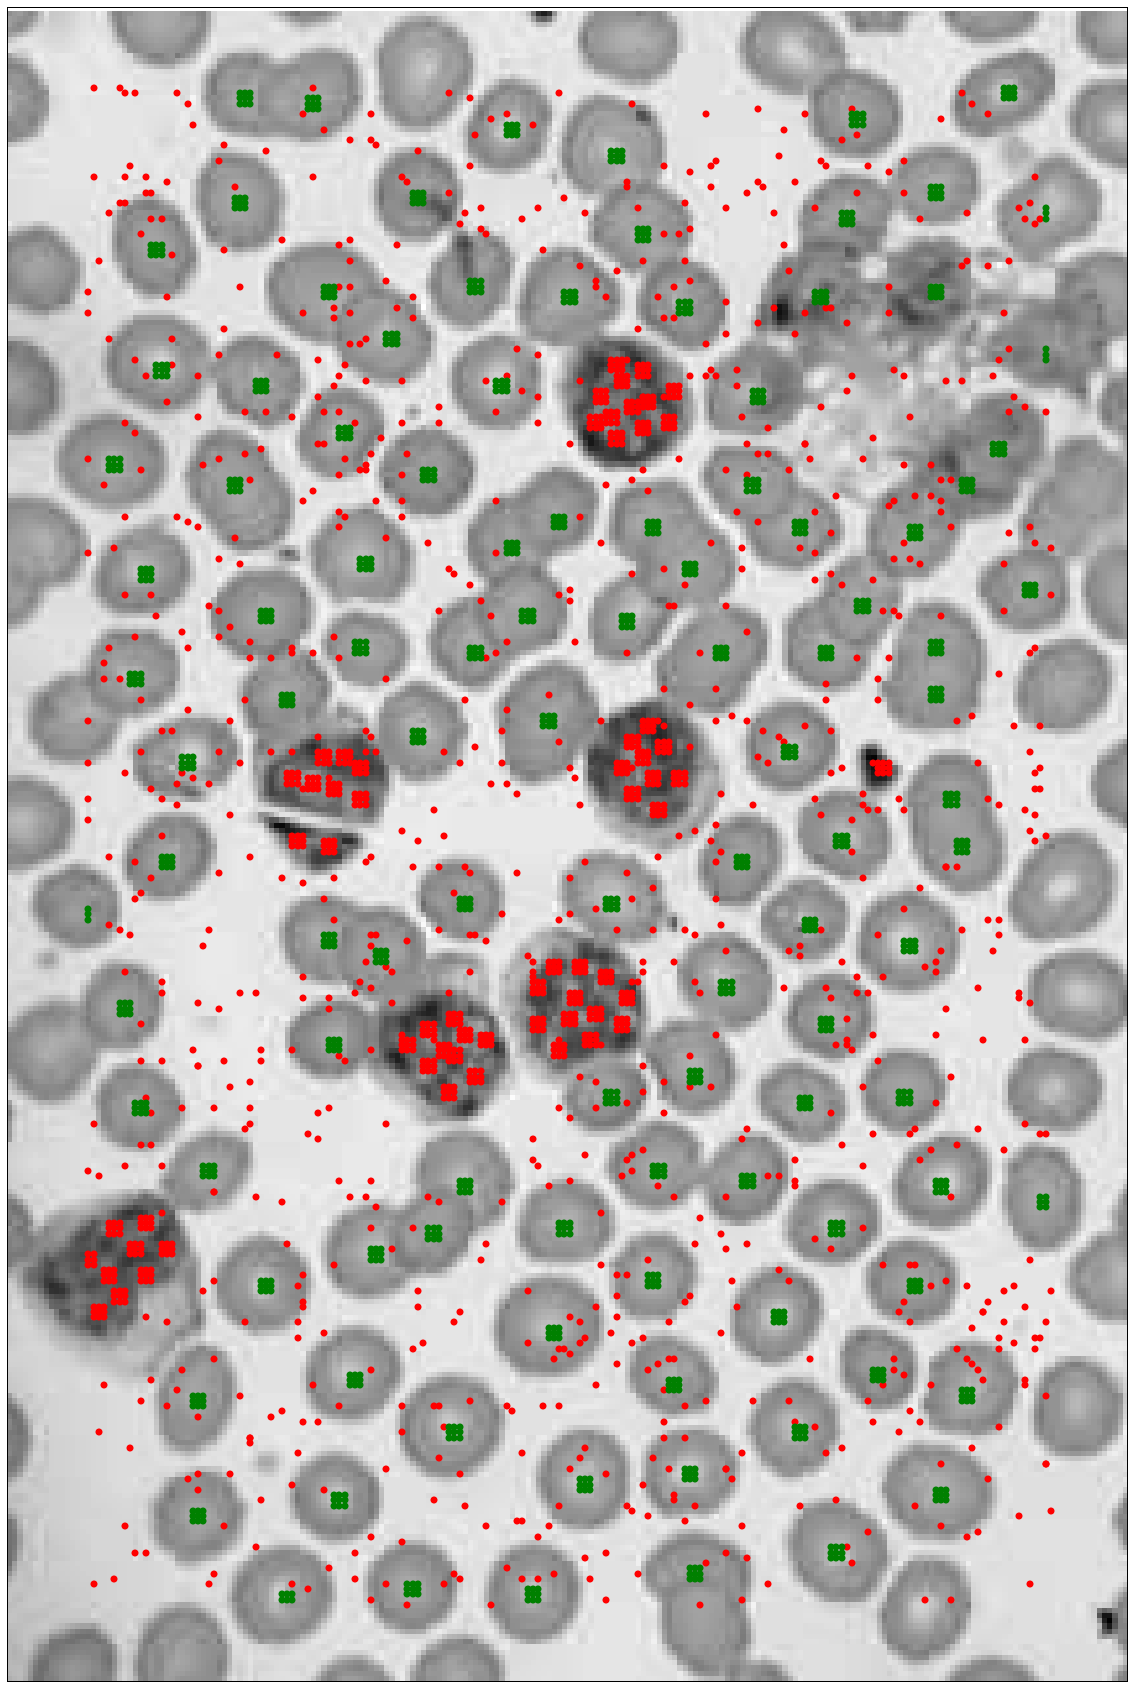

In [6]:
fig, ax = plt.subplots()
ax.imshow(t_img, interpolation='nearest', cmap=plt.cm.gray)
pos_ids = [idx for idx in range(len(t_labels)) if t_labels[idx] == 1]
neg_ids = [idx for idx in range(len(t_labels)) if t_labels[idx] == 0]

plt.plot(t_samples[neg_ids,1], t_samples[neg_ids,0], 'r.', markersize=10, mew=2)
plt.plot(t_samples[pos_ids,1], t_samples[pos_ids,0], 'g.', markersize=10, mew=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()
plt.rcParams['figure.figsize'] = 30,30

## Setup network

In [7]:
input_var = T.tensor4('inputs')
target_var = T.ivector('targets')
network = setup_network(input_var, box_size)

## Setup objective function

In [8]:
# Training
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var).mean()
train_acc = T.mean(T.eq(T.argmax(prediction, axis=1), target_var), dtype=theano.config.floatX)
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=learning_rate, momentum=0.9)
train_fn = theano.function([input_var, target_var], [loss, train_acc], updates=updates, allow_input_downcast=True)

# Validation
val_prediction = lasagne.layers.get_output(network, deterministic=True)
val_loss = lasagne.objectives.categorical_crossentropy(val_prediction, target_var).mean()
val_acc = T.mean(T.eq(T.argmax(val_prediction, axis=1), target_var), dtype=theano.config.floatX)
val_fn = theano.function([input_var, target_var], [val_loss, val_acc], allow_input_downcast=True)

## Optimize parameters

In [9]:
for epoch in xrange(num_epochs):
    train_batches = 0
    val_batches = 0
    train_err = 0
    train_acc = 0
    val_err = 0
    val_acc = 0
    start_time = time.time()

    for batch in minibatch_iterator(t_samples, t_labels, t_img, box_size, batchsize = 100, shuffle=True):
        inputs, targets = batch
        err, acc = train_fn(inputs, targets)
        train_err += err
        train_acc += acc
        train_batches += 1

    for batch in minibatch_iterator(v_samples, v_labels, v_img, box_size, batchsize = 100, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        val_err += err
        val_acc += acc
        val_batches += 1

    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t{:.6f}".format(train_err / train_batches))
    print("  Training accuracy:\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation loss:\t{:.6f}".format(val_err / val_batches))
    print("  validation accuracy:\t{:.2f} %".format(val_acc / val_batches * 100))

Epoch 1 of 15 took 15.310s
  training loss:	0.621473
  Training accuracy:	63.12 %
  validation loss:	0.441004
  validation accuracy:	87.08 %
Epoch 2 of 15 took 15.258s
  training loss:	0.364696
  Training accuracy:	86.29 %
  validation loss:	0.171448
  validation accuracy:	95.40 %
Epoch 3 of 15 took 14.942s
  training loss:	0.219643
  Training accuracy:	91.42 %
  validation loss:	0.121565
  validation accuracy:	95.76 %
Epoch 4 of 15 took 14.942s
  training loss:	0.176623
  Training accuracy:	93.46 %
  validation loss:	0.113758
  validation accuracy:	95.72 %
Epoch 5 of 15 took 14.800s
  training loss:	0.160945
  Training accuracy:	94.29 %
  validation loss:	0.106985
  validation accuracy:	96.36 %
Epoch 6 of 15 took 14.450s
  training loss:	0.145985
  Training accuracy:	94.46 %
  validation loss:	0.103349
  validation accuracy:	96.12 %
Epoch 7 of 15 took 14.236s
  training loss:	0.149506
  Training accuracy:	94.58 %
  validation loss:	0.101953
  validation accuracy:	96.36 %
Epoch 8 of 15

## Sliding window

In [10]:
eval_fn = theano.function([input_var], val_prediction)
output = np.zeros((v_img.shape[0], v_img.shape[1], 2))

margin = int(math.floor(box_size / 2))
for x in xrange(margin, int(v_img.shape[0] - margin)):
    for y in xrange(margin, int(v_img.shape[1]-margin)):
        patch = v_img[x-margin:x+margin+1, y-margin:y+margin+1]
        patch = patch.reshape(1,1, box_size, box_size)
        output[x,y,:] = eval_fn(patch)

### Plot detections (local maxima)

In [ ]:
fig, ax = plt.subplots()
ax.imshow(v_img, interpolation='nearest', cmap=plt.cm.gray)

heatmap = filters.gaussian_filter(output[:,:,1], 1) 
seg = heatmap>0.5

xy = np.where(np.multiply(seg, heatmap == filters.maximum_filter(heatmap, 3)))

plt.plot(xy[1], xy[0], 'rx', markersize=10, mew=2)
        
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()
plt.rcParams['figure.figsize'] = 20,20